## Machine learning in text mining
* Corpora 语料
* stop words 停用词

## 模型是一条直线

311
[14.5 14.5]
[157.5]
157.5
157.5


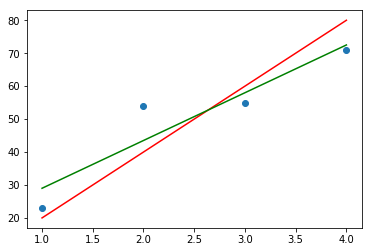

In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

x = np.array([1,2,3,4])
y = np.array([23,54,55,71])
plt.plot(x,y,'o')


#第一代模型
f = lambda n: n*20

#近似误差函数
def error(f, x, y):
    return sp.sum((f(x) - y)**2)

print(error(f, x, y)) #[311]近似误差
plt.plot(x,f(x), 'r')

fp1, residuals, rank, sv, rconf = sp.polyfit(x, y, 1, full=True)
print(fp1) #[14.5 14.5]
print(residuals) #[157.5] 近似误差

f2 = lambda n: 14.5*n + 14.5
print(error(f2, x, y))

f3 = sp.poly1d(fp1) # build the model f3, f3 is actuall == f2
print(error(f3, x, y))
plt.plot(x,f3(x), 'g')

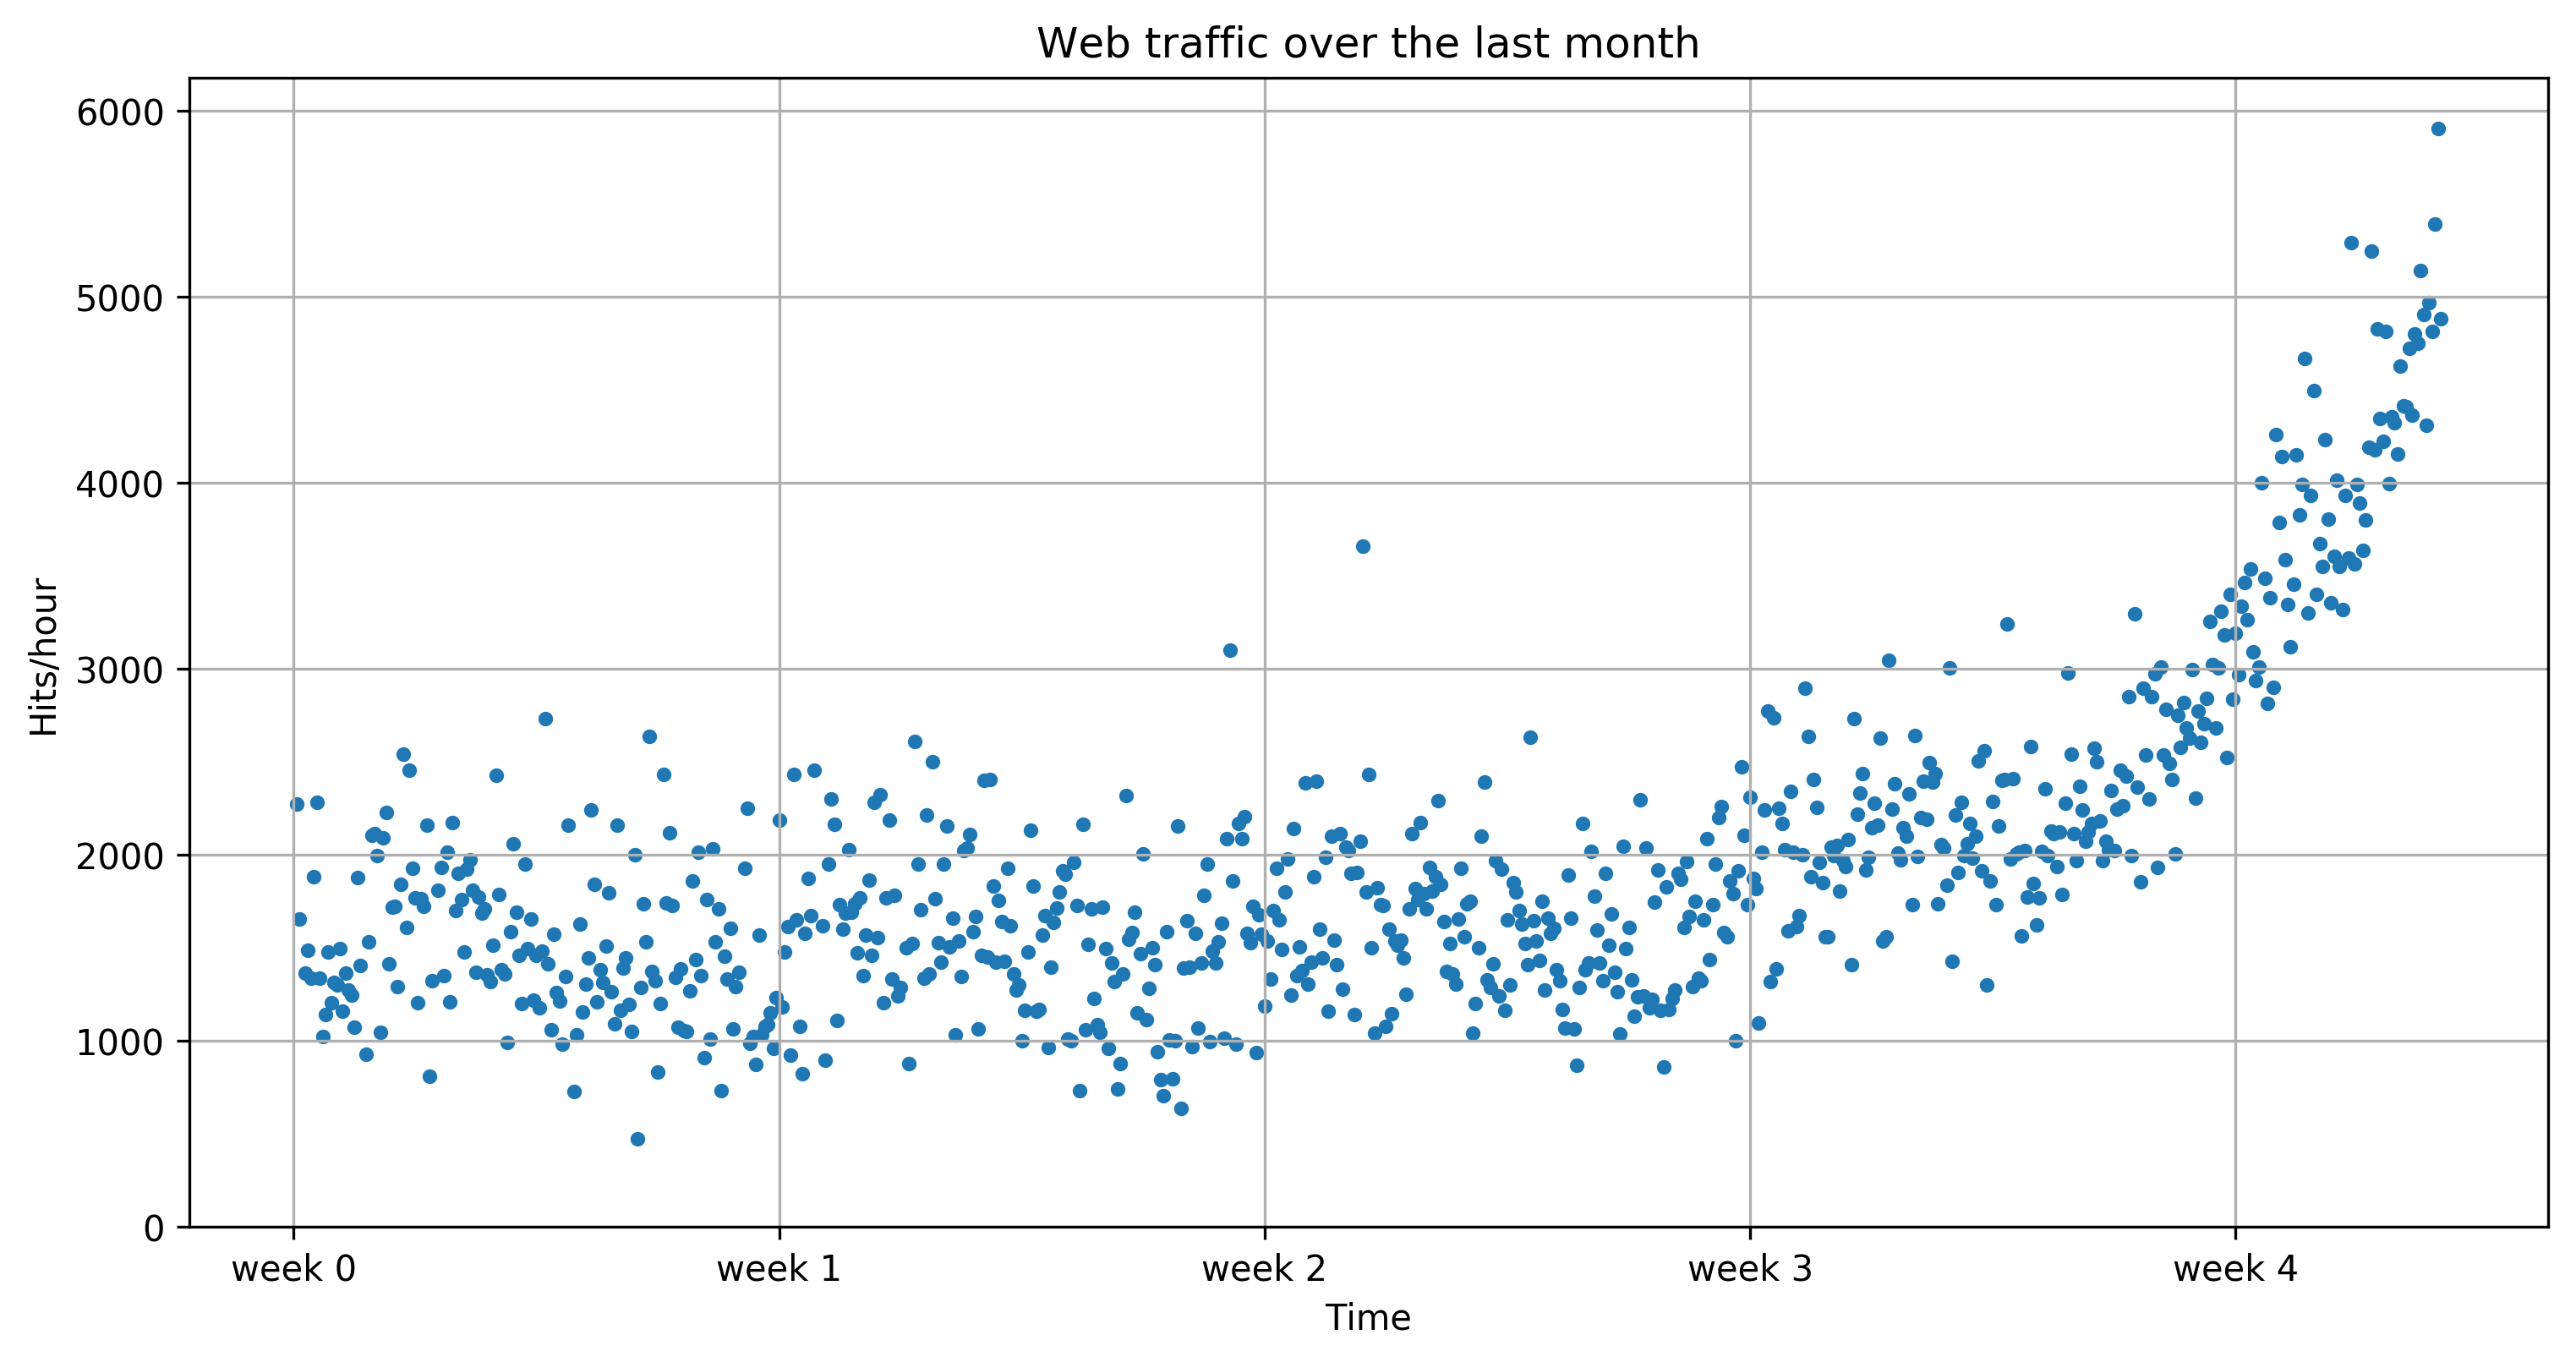

In [3]:
# This script generates web traffic data for our hypothetical
# web startup "MLaaS"

import os
import numpy as np
import scipy as sp
from scipy.stats import gamma
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), "data")
CHART_DIR = os.path.join(os.getcwd(), "charts")

for d in [DATA_DIR, CHART_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

np.random.seed(3)  # to reproduce the data later on

def gen_web_traffic_data():
    '''
    This function generates some fake data that first shows a weekly pattern 
    for a couple weeks before it grows exponentially.
    '''
    x = np.arange(1, 31*24)
    y = np.array(200*(np.sin(2*np.pi*x/(7*24))), dtype=np.float32)
    y += gamma.rvs(15, loc=0, scale=100, size=len(x))
    y += 2 * np.exp(x/100.0)
    y = np.ma.array(y, mask=[y<0])

    # We introduce some "real-world" data, to later demonstrate how to clean 
    # it conveniently.
    y[[2,23,48,95,154,180,181,210]] = np.nan

    return x, y

def plot_web_traffic(x, y, models=None, mx=None, ymax=None, fig_idx=None):
    '''
    Plot the web traffic (y) over time (x). 
    
    If models is given, it is expected to be a list fitted models,
    which will be plotted as well (used later in this chapter).
    '''
    plt.figure(figsize=(12,6), dpi=300) # width and height of the plot in inches
    plt.scatter(x, y, s=10)
    plt.title("Web traffic over the last month")
    plt.xlabel("Time")
    plt.ylabel("Hits/hour")
    plt.xticks([w*7*24 for w in range(20)], 
               ['week %i' %w for w in range(20)])
    
    if models:
        colors = ['g', 'k', 'b', 'm', 'r']
        linestyles = ['-', '-.', '--', ':', '-']

        if mx is None:
            mx = np.linspace(0, x[-1], 1000)
        for model, style, color in zip(models, linestyles, colors):
            plt.plot(mx, model(mx), linestyle=style, linewidth=2, c=color)

        plt.legend(["d=%i" % m.order for m in models], loc="upper left")
        
    plt.autoscale()
    if ymax:
        plt.ylim(ymax=ymax)

    plt.grid()
    plt.ylim(ymin=0)
    
    if fig_idx is not None:
        plt.savefig(os.path.join(CHART_DIR, "B09124_01_%s.png" % fig_idx))
        
x, y = gen_web_traffic_data()
np.savetxt(os.path.join(DATA_DIR, "web_traffic.tsv"), 
           list(zip(x, y)), delimiter="\t", fmt="%f")
    
plot_web_traffic(x, y)

In [4]:
data = np.genfromtxt(os.path.join(DATA_DIR, "web_traffic.tsv"), delimiter="\t")
print(data)

[[1.00000000e+00 2.27333106e+03]
 [2.00000000e+00 1.65725549e+03]
 [3.00000000e+00            nan]
 ...
 [7.41000000e+02 5.39354199e+03]
 [7.42000000e+02 5.90681494e+03]
 [7.43000000e+02 4.88302246e+03]]


In [5]:
print(data.shape)

(743, 2)


In [6]:
# So we have to remove all data from x and y where y is NaN.
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

In [31]:
print(x)

[  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 25

In [7]:
fp1 = np.polyfit(x, y, 1)
print("Model parameters: %s" % fp1)


def error(f, x, y):
    return np.sum((f(x)-y)**2)


f1 = np.poly1d(fp1)
print(error(f1, x, y))

Model parameters: [  2.58462016 996.50674246]
319531507.00812596


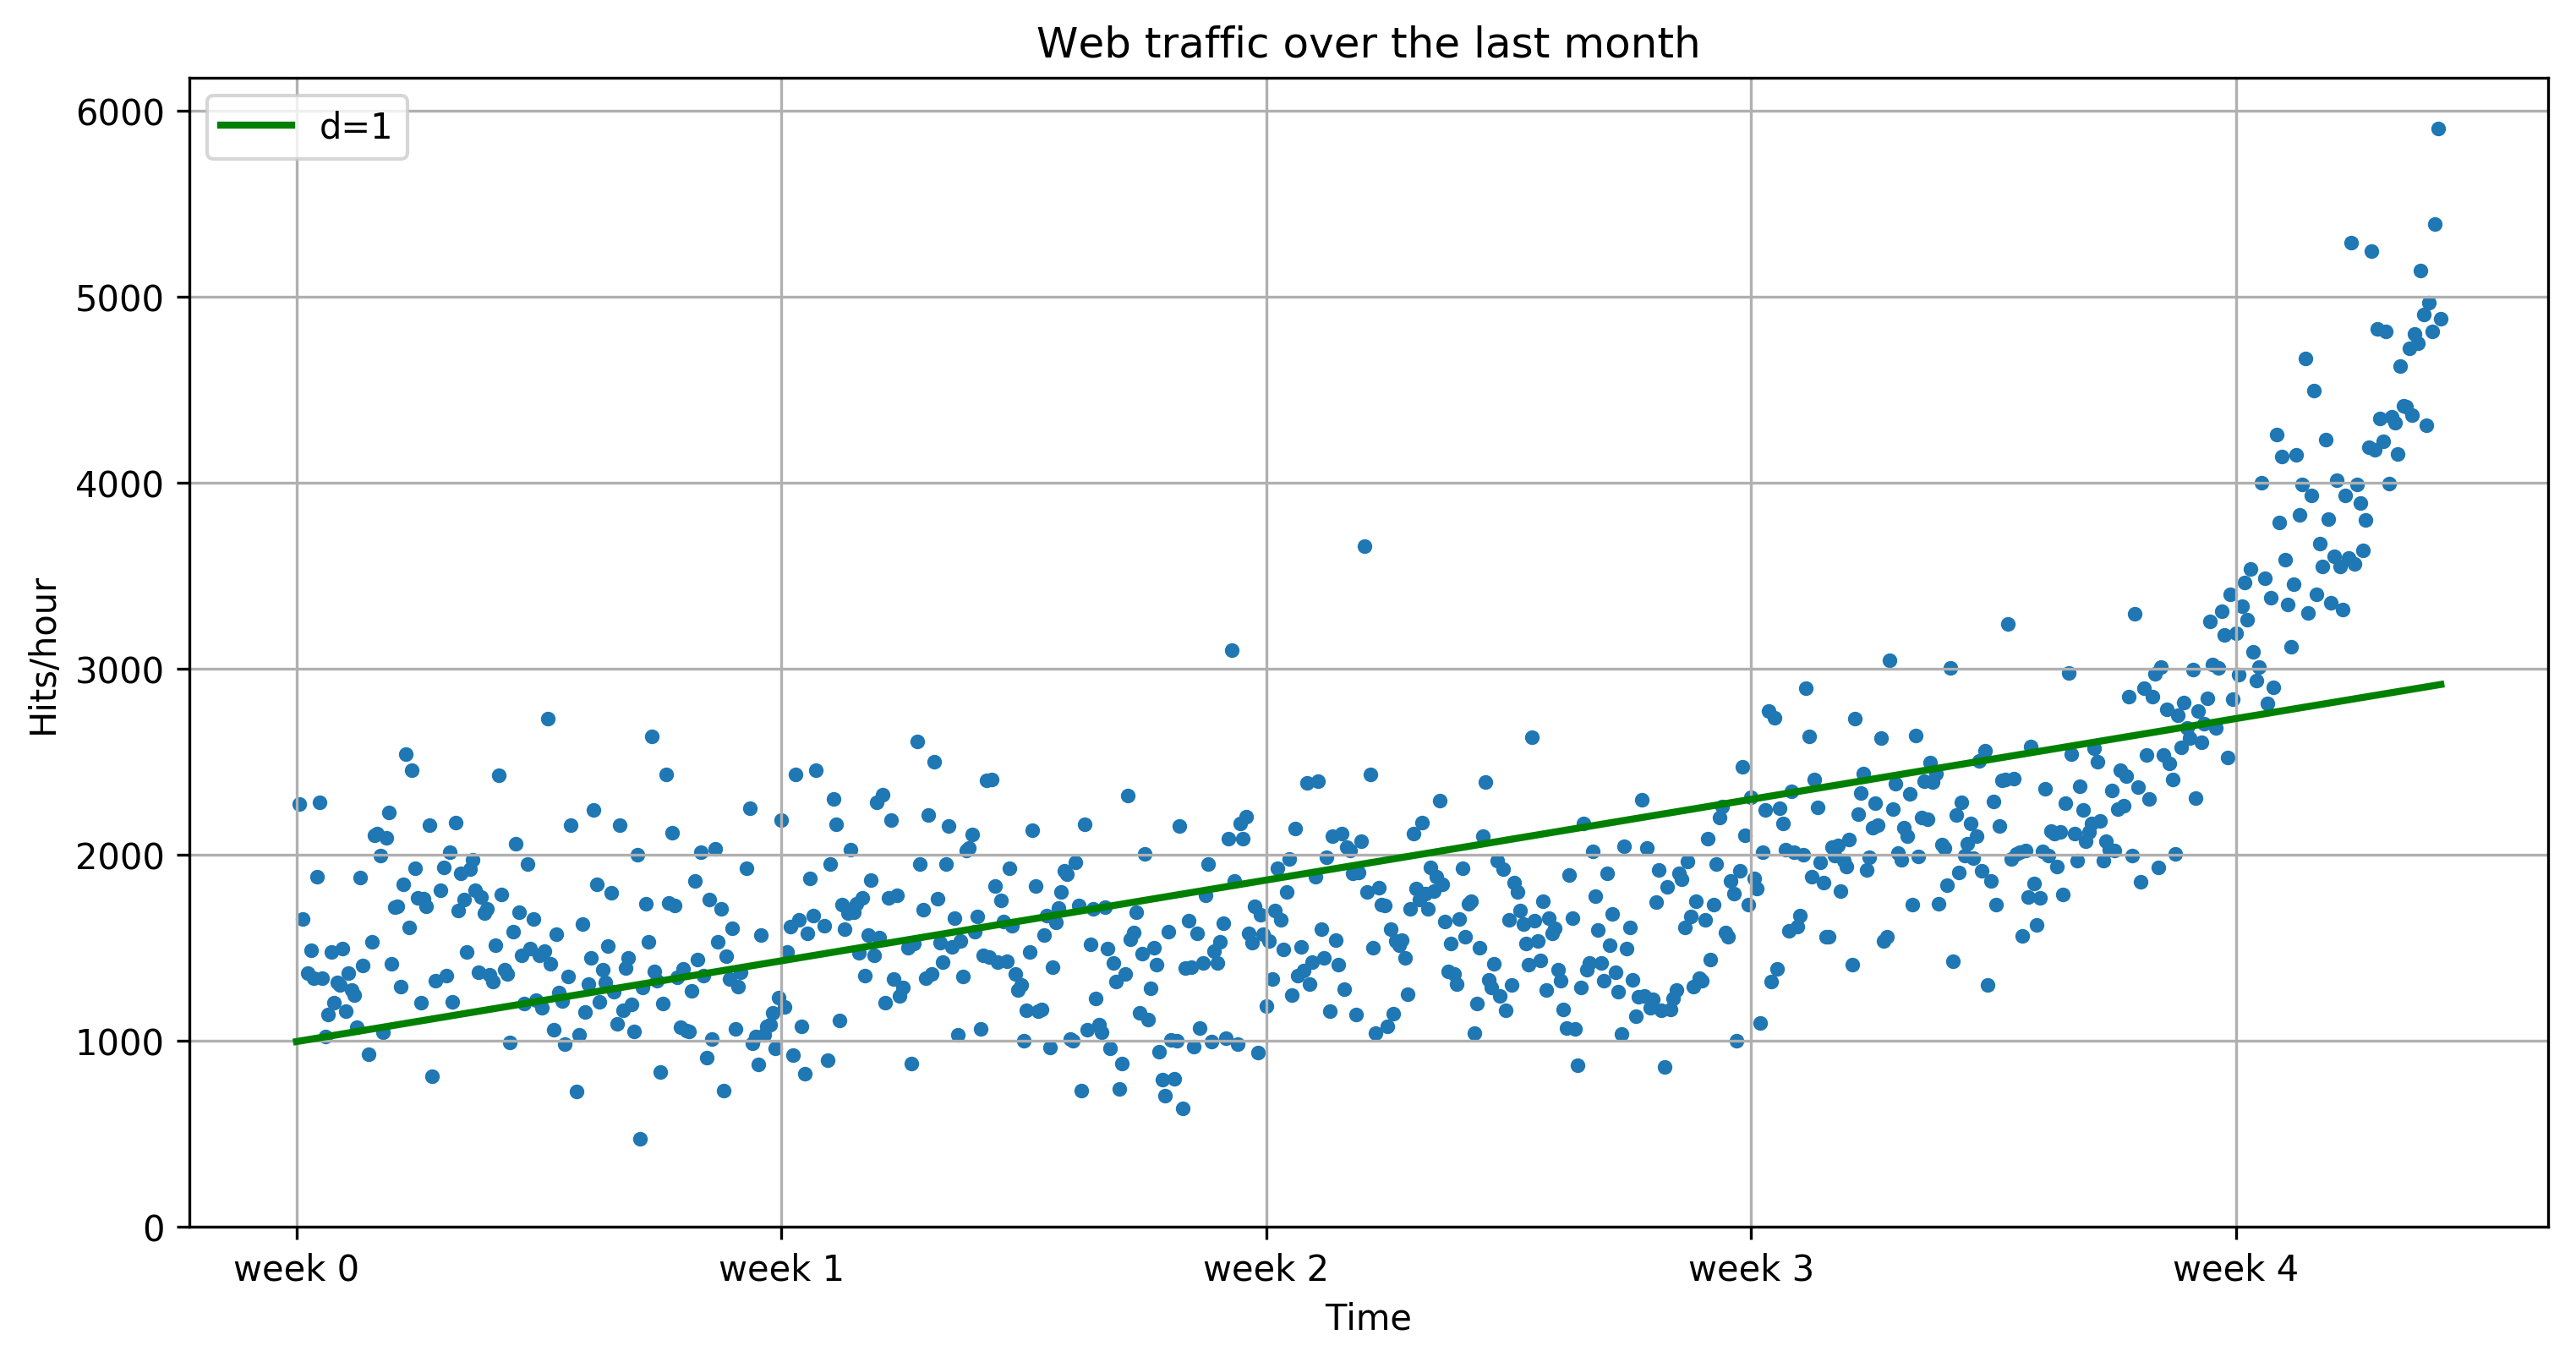

In [8]:
plot_web_traffic(x, y, [f1])

In [9]:
f2p = np.polyfit(x, y, 2)
print(f2p)

[ 1.05605675e-02 -5.29774287e+00  1.98466917e+03]


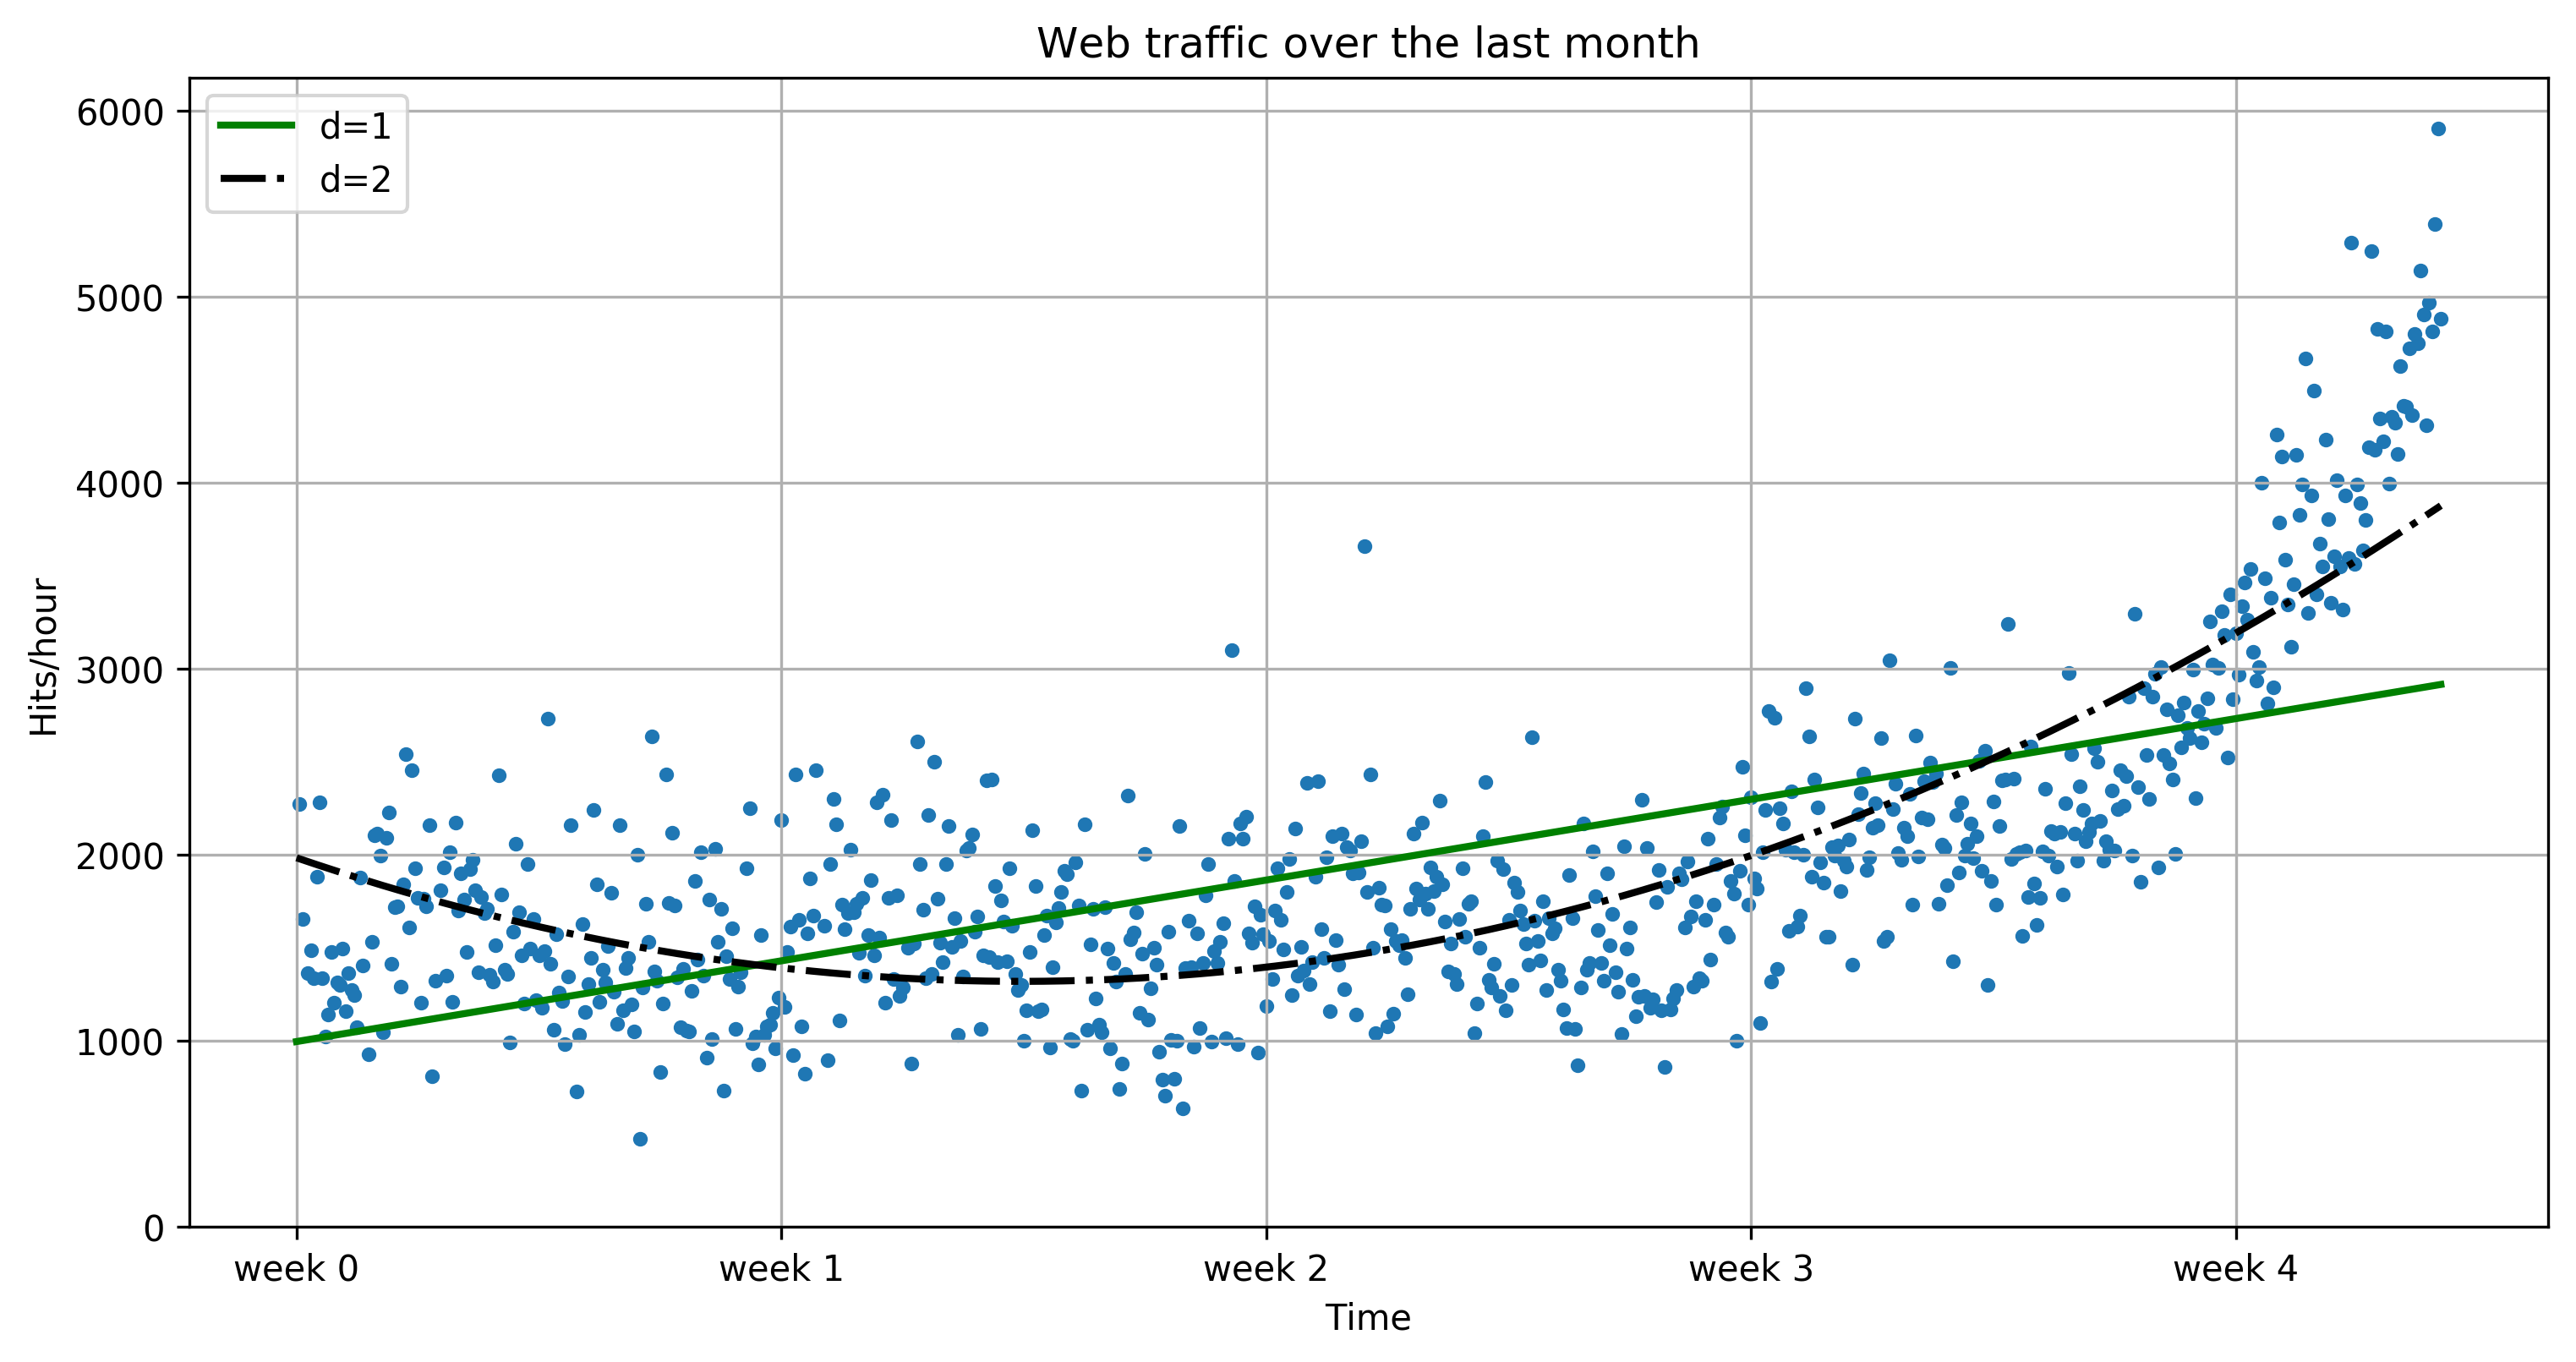

In [10]:
f2 = np.poly1d(f2p)
plot_web_traffic(x, y, [f1, f2])

### 什么时候才能达到 10000 hits/hour?

In [11]:
from scipy.optimize import fsolve

# f2 - 10000: fsolve是计算func(x) = 0
# x0: start from hour 800
reached_max = fsolve(f2-100000, x0=800)/(7*24)
print("100,000 hits/hour expected at week %f" % reached_max[0])

100,000 hits/hour expected at week 19.688394


### Iris data set

In [16]:
from sklearn.datasets import load_iris 

iris = load_iris() 
print(iris.feature_names)
print(iris.data)
print(iris.data.shape)
print(iris.target_names)
print(iris.target)
print(iris.target.shape)


['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3

* `fit(features, labels)`: This is the learning step and fits the parameters of the model. It takes a list-like object with features and another with labels as arguments.
* `predict(features)`: This method can only be called after fit and returns a prediction for one or more inputs.